# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.model_evaluation as me
from scripts.model_training import Model
import scripts.tree_model_training as tm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit


## Pre-process data

In [2]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [3]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
print(f'train_iq shape: {train_iq.shape}') 
print(f'train_sj shape: {train_sj.shape}') 
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()

train_iq shape: (518, 24)
train_sj shape: (928, 24)


In [4]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
Xy_iq = fe.shift_features(Xy_iq, periods=1)
Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)

Text(0.5, 1.0, 'San Juan Variable Correlations')

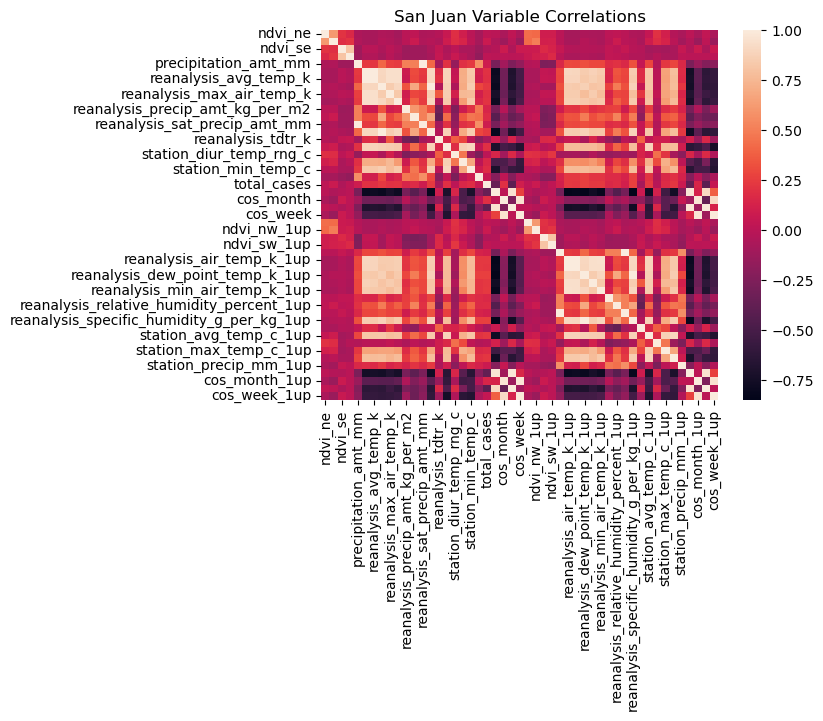

In [5]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')


In [6]:
#(Xy_sj.total_cases
#   .drop('total_cases', axis=1) # don't compare with myself
#   .sort_values(ascending=False)
#   .plot
#   .barh())

In [7]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

## Train model

In [8]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.075651627174025
        RMSE test: 9.075651627174025
        MAE train: 6.223892490899363
        MAE test: 6.223892490899363 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.07577839160705
        RMSE test: 39.07577839160705
        MAE train: 24.207119741100325
        MAE test: 24.207119741100325 
    


(39.07577839160705, 39.07577839160705, 24.207119741100325, 24.207119741100325)

In [9]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_train,mae_test,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda
0,1,8.269286,0.177602,0.121401,5.671403,0.1,100,5,1.0,1.0,2
1,1,8.270862,0.009906,0.006985,5.683930,0.1,200,5,1.0,1.0,2
2,2,11.477965,0.622729,0.434704,6.797968,0.1,100,5,1.0,1.0,2
3,2,11.495313,0.113670,0.076066,6.806906,0.1,200,5,1.0,1.0,2


In [10]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_train,mae_test,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda
0,1,43.156531,1.438983,1.057598,25.761389,0.1,100,5,1.0,1.0,2
1,1,43.302428,0.257941,0.184401,25.904488,0.1,200,5,1.0,1.0,2
2,2,36.427232,5.459270,3.868991,28.608672,0.1,100,5,1.0,1.0,2
3,2,36.786371,1.625402,1.132557,28.984965,0.1,200,5,1.0,1.0,2


## Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [11]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


(517, 48) (517, 1)
(927, 48) (927, 1)


In [12]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.1,
        n_estimators=150,
        max_depth=5,
        subsample=1.0,
        colsample_bytree=1.0,
        reg_lambda=2)

# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [26]:
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [27]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission4.csv', index=False)

Writing submission file to folder: 


In [ ]:

# Perform final predictions and reformat for submission
#final_iq = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, 
#              city='iq', model=model_iq, params=params_iq)
#final_sj = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, 
#              city='sj', model=model_sj, params=params_sj)

# Merge the two cities into one DataFrame and write to new csv file 
#final_comb = fp.write_submission(final_iq, final_sj) 

In [ ]:
# Merge the two cities into one DataFrame and write to new csv file 
final = pd.concat([final_sj, final_iq], axis=0)
final['id'] = final.city.astype(str) + '_' + final.year.astype(str) + '_' + final.weekofyear.astype(str)
correct_cols = test_features.loc[:, ['city','weekofyear','year']]
correct_cols['id'] = correct_cols.city.astype(str) + '_' + correct_cols.year.astype(str) + '_' + correct_cols.weekofyear.astype(str)
final = pd.merge(final, correct_cols, on=['id'], how='left')
final = final.loc[:,['city_x','year_x','weekofyear_x','total_cases']]
final.columns = ['city','year','weekofyear','total_cases']
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [ ]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission3.csv', index=False)